# Data Loading

In [1]:
!pip install -q optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna  # Bayesian Optimization Library
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

# Load your dataset into a DataFrame
df = pd.read_csv("TampinesResaleFlat_with_LatLong_with_Features.csv")

# Data Inspection

In [2]:
df.shape

(13363, 22)

In [3]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'Full Address', 'Latitude',
       'Longitude', 'nearest_bus_stop_distance', 'nearest_mrt_distance',
       'nearest_mall_distance', 'nearest_school_distance', 'bus_stop_count',
       'mrt_count', 'mall_count', 'school_count'],
      dtype='object')

In [4]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,Latitude,Longitude,nearest_bus_stop_distance,nearest_mrt_distance,nearest_mall_distance,nearest_school_distance,bus_stop_count,mrt_count,mall_count,school_count
0,2017-01,TAMPINES,2 ROOM,299A,TAMPINES ST 22,01 TO 03,45,Model A,2012,94 years 02 months,...,1.350005,103.953938,74.413446,NaN,NaN,308.671041,13.0,0.0,0.0,4.0
1,2017-01,TAMPINES,3 ROOM,403,TAMPINES ST 41,01 TO 03,60,Improved,1985,67 years 09 months,...,1.357512,103.944918,72.814515,457.922913,369.959209,465.132319,15.0,1.0,2.0,4.0
2,2017-01,TAMPINES,3 ROOM,802,TAMPINES AVE 4,04 TO 06,68,New Generation,1984,66 years 05 months,...,1.346084,103.938034,120.999263,NaN,NaN,203.682444,12.0,0.0,0.0,4.0
3,2017-01,TAMPINES,3 ROOM,410,TAMPINES ST 41,01 TO 03,69,Improved,1985,67 years 08 months,...,1.358778,103.946271,114.172862,NaN,526.408805,315.694223,12.0,0.0,1.0,4.0
4,2017-01,TAMPINES,3 ROOM,462,TAMPINES ST 44,07 TO 09,64,Simplified,1987,69 years 06 months,...,1.359013,103.955111,93.841568,NaN,NaN,229.786957,20.0,0.0,0.0,2.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13363 entries, 0 to 13362
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      13363 non-null  object 
 1   town                       13363 non-null  object 
 2   flat_type                  13363 non-null  object 
 3   block                      13363 non-null  object 
 4   street_name                13363 non-null  object 
 5   storey_range               13363 non-null  object 
 6   floor_area_sqm             13363 non-null  int64  
 7   flat_model                 13363 non-null  object 
 8   lease_commence_date        13363 non-null  int64  
 9   remaining_lease            13363 non-null  object 
 10  resale_price               13363 non-null  int64  
 11  Full Address               13363 non-null  object 
 12  Latitude                   13363 non-null  float64
 13  Longitude                  13363 non-null  flo

In [6]:
df.isnull().sum()

,0
month,0
town,0
flat_type,0
block,0
street_name,0
storey_range,0
floor_area_sqm,0
flat_model,0
lease_commence_date,0
remaining_lease,0


# Data Cleaning

In [7]:
# Replacing NaN values with 0 for the count variables (bus_stop_count, mrt_count, mall_count, school_count)
df['bus_stop_count'] = df['bus_stop_count'].fillna(0)
df['mrt_count'] = df['mrt_count'].fillna(0)
df['mall_count'] = df['mall_count'].fillna(0)
df['school_count'] = df['school_count'].fillna(0)

# Check for missing values again to ensure the counts are handled
df.isnull().sum()

,0
month,0
town,0
flat_type,0
block,0
street_name,0
storey_range,0
floor_area_sqm,0
flat_model,0
lease_commence_date,0
remaining_lease,0


In [8]:
# Set a random seed for reproducibility
np.random.seed(42)

# Drop rows where 'nearest_school_distance' is missing
df.dropna(subset=['nearest_school_distance'], inplace=True)

# Fill missing values for other columns with random sampling within the range 501-1000
columns_to_fill = ['nearest_mrt_distance', 'nearest_mall_distance', 'nearest_bus_stop_distance']

for column in columns_to_fill:
    if df[column].isnull().sum() > 0:  # Only fill if there are missing values
        df[column] = df[column].apply(lambda x: np.random.randint(501, 1001) if pd.isnull(x) else x)

# Check for missing values again
df.isnull().sum()

,0
month,0
town,0
flat_type,0
block,0
street_name,0
storey_range,0
floor_area_sqm,0
flat_model,0
lease_commence_date,0
remaining_lease,0


In [9]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")

Missing Values:
 Series([], dtype: int64)

Number of duplicate rows: 3


In [10]:
# Remove duplicates
df = df.drop_duplicates()

# Confirm that duplicates are removed
print(f"Number of duplicate rows after cleaning: {df.duplicated().sum()}")

Number of duplicate rows after cleaning: 0


In [11]:
#Split the month column into two separate columns: year and month
df['year'] = df['month'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['month'].apply(lambda x: int(x.split('-')[1]))

<ipython-input-11-f62e71732cc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['month'].apply(lambda x: int(x.split('-')[0]))
<ipython-input-11-f62e71732cc5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['month'].apply(lambda x: int(x.split('-')[1]))


In [12]:
def convert_to_months(lease_str):
    # Check if the lease string includes a months portion
    if "months" in lease_str:
        # Expected format: "<years> years <months> months"
        years = int(lease_str.split(" years ")[0])
        months = int(lease_str.split(" years ")[1].split(" months")[0])
    else:
        # Format with only years: "<years> years"
        years = int(lease_str.split(" years")[0])
        months = 0
    return years * 12 + months

df['remaining_lease_months'] = df['remaining_lease'].apply(convert_to_months)
df.drop(columns=['remaining_lease'], inplace=True)

<ipython-input-12-4a438a69aacc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['remaining_lease_months'] = df['remaining_lease'].apply(convert_to_months)
<ipython-input-12-4a438a69aacc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['remaining_lease'], inplace=True)


In [13]:
# Initialize the encoder with drop='first' to avoid the dummy variable trap
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'flat_type' column
encoded_features = encoder.fit_transform(df[['flat_type']])

# Create a dataframe with the encoded features using the built-in method for feature names
feature_names = encoder.get_feature_names_out(['flat_type'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Concatenate the original dataframe (excluding flat_type) with the encoded features
df = pd.concat([df.drop('flat_type', axis=1), encoded_df], axis=1)

# Check the result
print(df.head())

   month      town block     street_name storey_range  floor_area_sqm  \
0    1.0  TAMPINES  299A  TAMPINES ST 22     01 TO 03            45.0   
1    1.0  TAMPINES   403  TAMPINES ST 41     01 TO 03            60.0   
2    1.0  TAMPINES   802  TAMPINES AVE 4     04 TO 06            68.0   
3    1.0  TAMPINES   410  TAMPINES ST 41     01 TO 03            69.0   
4    1.0  TAMPINES   462  TAMPINES ST 44     07 TO 09            64.0   

       flat_model  lease_commence_date  resale_price         Full Address  \
0         Model A               2012.0      250000.0  299A TAMPINES ST 22   
1        Improved               1985.0      270000.0   403 TAMPINES ST 41   
2  New Generation               1984.0      295000.0   802 TAMPINES AVE 4   
3        Improved               1985.0      300000.0   410 TAMPINES ST 41   
4      Simplified               1987.0      305000.0   462 TAMPINES ST 44   

   ...  mrt_count  mall_count  school_count    year  remaining_lease_months  \
0  ...        0.0  

In [14]:
# Initialize the encoder with drop='first' to drop the first category (similar to drop_first=True)
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'street_name' column
encoded_features = encoder.fit_transform(df[['street_name']])

# Create a dataframe with the encoded features
# Get the feature names and remove the 'street_name_' prefix for cleaner column names if desired
feature_names = encoder.get_feature_names_out(['street_name'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Concatenate the original dataframe (excluding street_name) with the encoded features
df = pd.concat([df.drop('street_name', axis=1), encoded_df], axis=1)

# Check the result
print(df.head())

   month      town block storey_range  floor_area_sqm      flat_model  \
0    1.0  TAMPINES  299A     01 TO 03            45.0         Model A   
1    1.0  TAMPINES   403     01 TO 03            60.0        Improved   
2    1.0  TAMPINES   802     04 TO 06            68.0  New Generation   
3    1.0  TAMPINES   410     01 TO 03            69.0        Improved   
4    1.0  TAMPINES   462     07 TO 09            64.0      Simplified   

   lease_commence_date  resale_price         Full Address  Latitude  ...  \
0               2012.0      250000.0  299A TAMPINES ST 22  1.350005  ...   
1               1985.0      270000.0   403 TAMPINES ST 41  1.357512  ...   
2               1984.0      295000.0   802 TAMPINES AVE 4  1.346084  ...   
3               1985.0      300000.0   410 TAMPINES ST 41  1.358778  ...   
4               1987.0      305000.0   462 TAMPINES ST 44  1.359013  ...   

   street_name_TAMPINES ST 61  street_name_TAMPINES ST 71  \
0                         0.0              

In [15]:
# Initialize the encoder with drop='first' to drop the first category (similar to drop_first=True)
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'flat_model' column
encoded_features = encoder.fit_transform(df[['flat_model']])

# Create a dataframe with the encoded features
feature_names = encoder.get_feature_names_out(['flat_model'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Concatenate the original dataframe (excluding flat_model) with the encoded features
df = pd.concat([df.drop('flat_model', axis=1), encoded_df], axis=1)

# Check the result
print(df.head())

   month      town block storey_range  floor_area_sqm  lease_commence_date  \
0    1.0  TAMPINES  299A     01 TO 03            45.0               2012.0   
1    1.0  TAMPINES   403     01 TO 03            60.0               1985.0   
2    1.0  TAMPINES   802     04 TO 06            68.0               1984.0   
3    1.0  TAMPINES   410     01 TO 03            69.0               1985.0   
4    1.0  TAMPINES   462     07 TO 09            64.0               1987.0   

   resale_price         Full Address  Latitude   Longitude  ...  \
0      250000.0  299A TAMPINES ST 22  1.350005  103.953938  ...   
1      270000.0   403 TAMPINES ST 41  1.357512  103.944918  ...   
2      295000.0   802 TAMPINES AVE 4  1.346084  103.938034  ...   
3      300000.0   410 TAMPINES ST 41  1.358778  103.946271  ...   
4      305000.0   462 TAMPINES ST 44  1.359013  103.955111  ...   

   flat_model_DBSS  flat_model_Improved  flat_model_Maisonette  \
0              0.0                  0.0                    0.0

In [16]:
import pandas as pd
import numpy as np

# Function to convert storey range to average floor level
def convert_storey_range(range_str):
    if isinstance(range_str, str):  # Ensure the value is a string before processing
        low, high = map(int, range_str.replace(' TO ', ' ').split())
        return (low + high) / 2
    return np.nan  # Return NaN if the value is not a string

# Convert storey_range to average floor level and create a new column 'storey_level'
df['storey_level'] = df['storey_range'].apply(convert_storey_range)

# Drop the 'storey_range' column as it's no longer needed
df.drop(columns=['storey_range'], inplace=True)

# Display the first few rows of the modified dataframe
df.head()

,month,town,block,floor_area_sqm,lease_commence_date,resale_price,Full Address,Latitude,Longitude,nearest_bus_stop_distance,...,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_nan,storey_level
0,1.0,TAMPINES,299A,45.0,2012.0,250000.0,299A TAMPINES ST 22,1.350005,103.953938,74.413446,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,1.0,TAMPINES,403,60.0,1985.0,270000.0,403 TAMPINES ST 41,1.357512,103.944918,72.814515,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,1.0,TAMPINES,802,68.0,1984.0,295000.0,802 TAMPINES AVE 4,1.346084,103.938034,120.999263,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0
3,1.0,TAMPINES,410,69.0,1985.0,300000.0,410 TAMPINES ST 41,1.358778,103.946271,114.172862,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,1.0,TAMPINES,462,64.0,1987.0,305000.0,462 TAMPINES ST 44,1.359013,103.955111,93.841568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0


In [17]:
# Drop the original 'town' column
df.drop(columns=['town'], inplace=True, errors='ignore')

In [18]:
df.drop(columns=['block'], inplace=True, errors='ignore')

In [19]:
# Drop the original 'full address' column
df.drop(columns=['Full Address'], inplace=True, errors='ignore')

# Check the result
print(df.head())

   month  floor_area_sqm  lease_commence_date  resale_price  Latitude  \
0    1.0            45.0               2012.0      250000.0  1.350005   
1    1.0            60.0               1985.0      270000.0  1.357512   
2    1.0            68.0               1984.0      295000.0  1.346084   
3    1.0            69.0               1985.0      300000.0  1.358778   
4    1.0            64.0               1987.0      305000.0  1.359013   

    Longitude  nearest_bus_stop_distance  nearest_mrt_distance  \
0  103.953938                  74.413446            603.000000   
1  103.944918                  72.814515            457.922913   
2  103.938034                 120.999263            936.000000   
3  103.946271                 114.172862            849.000000   
4  103.955111                  93.841568            771.000000   

   nearest_mall_distance  nearest_school_distance  ...  flat_model_Improved  \
0             558.000000               308.671041  ...                  0.0   
1     

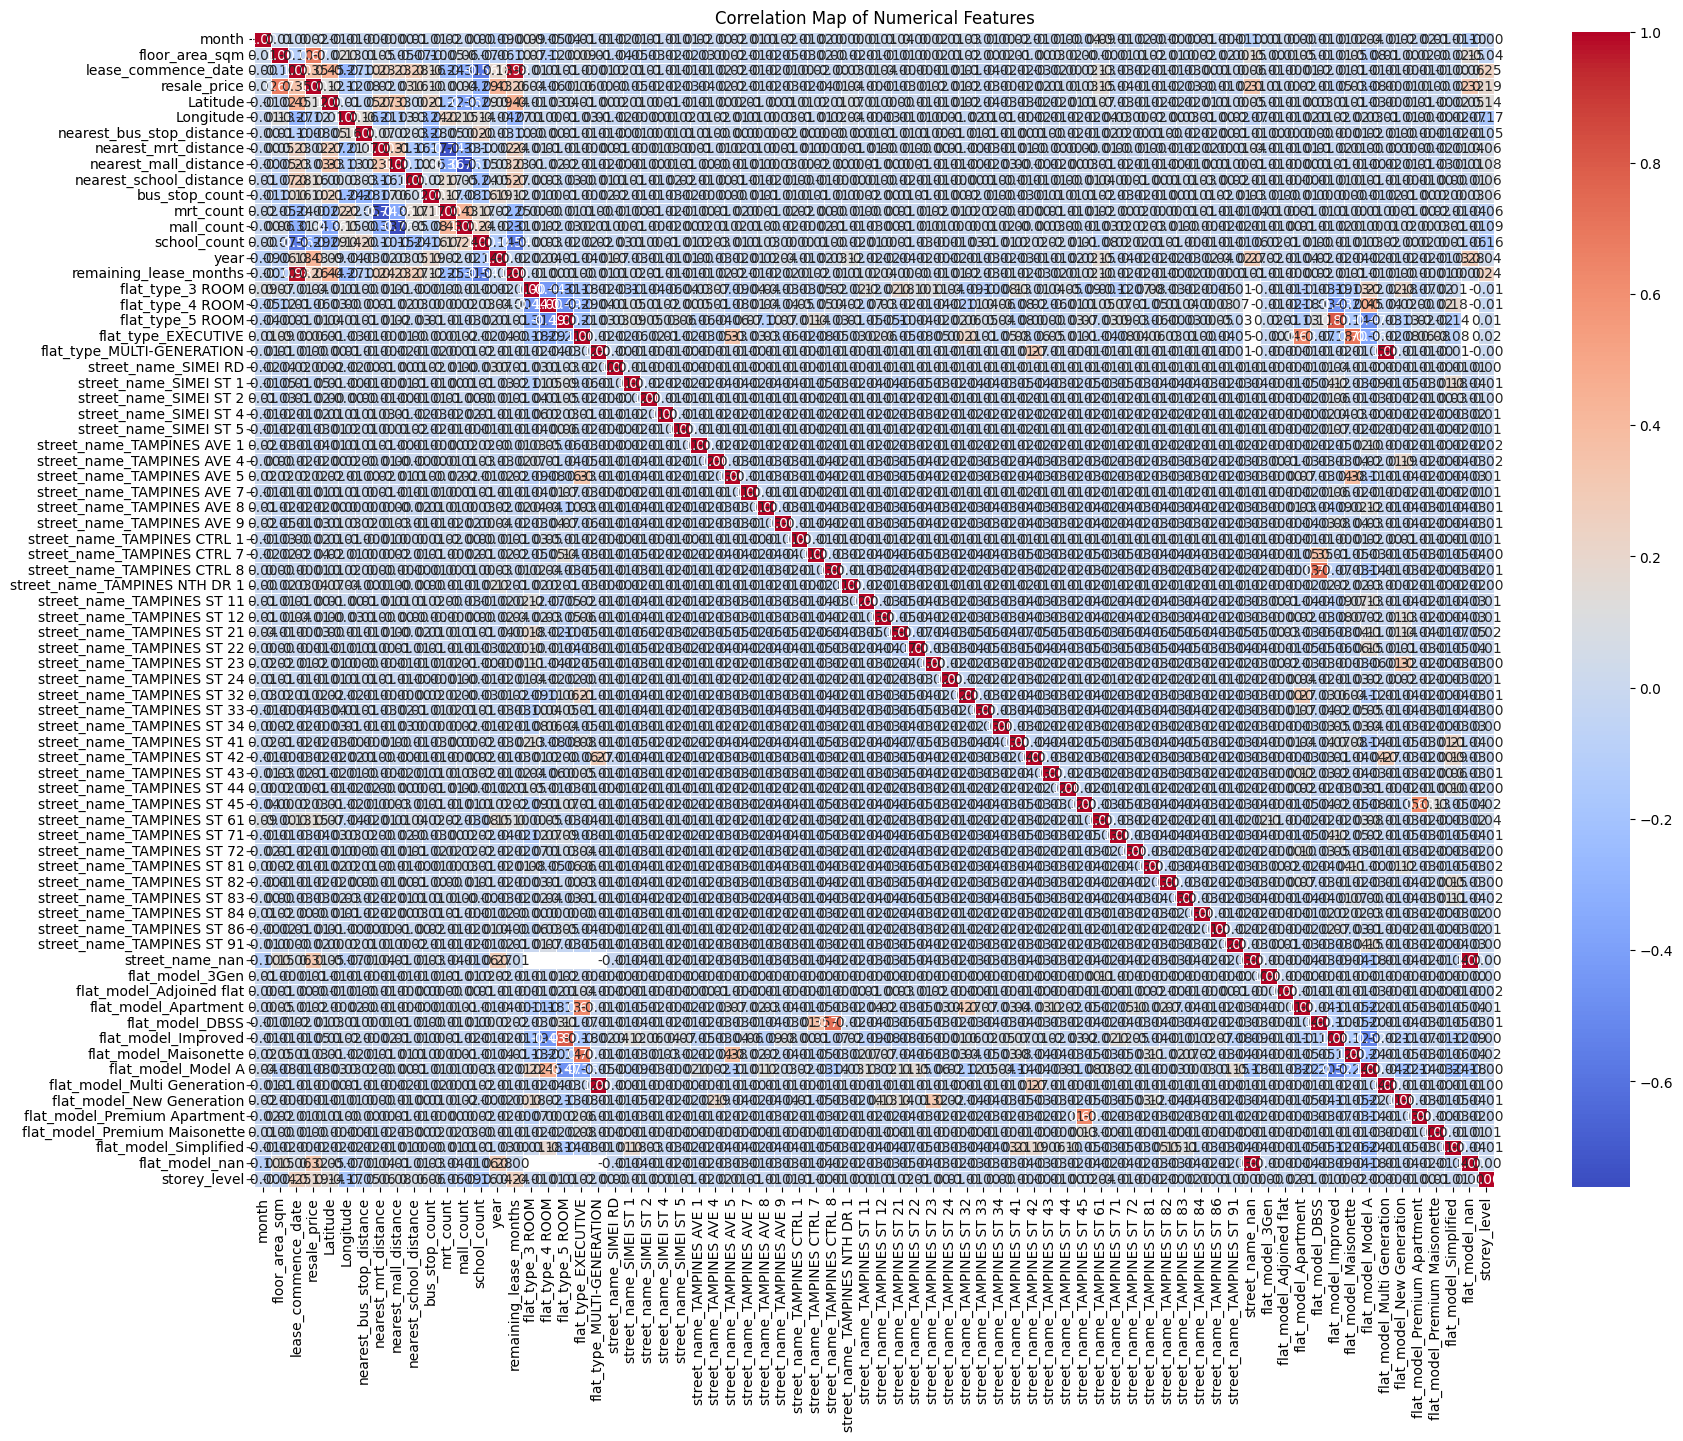

In [20]:
# Select numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_features.corr()

# Plot the correlation map
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Map of Numerical Features')
plt.show()

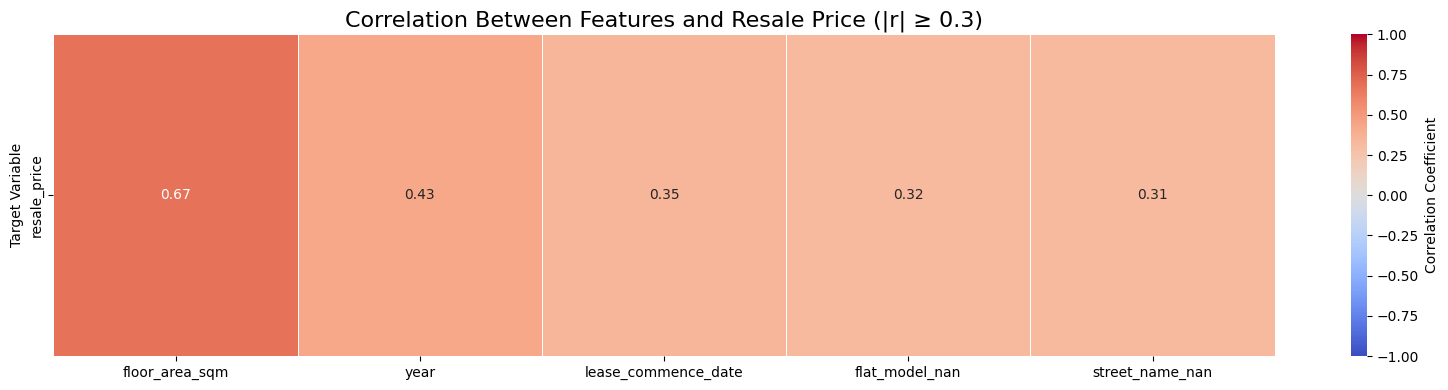

In [21]:
# Select numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlations with resale price
price_correlations = numerical_features.corr()['resale_price'].drop('resale_price')

# Define correlation threshold
threshold = 0.3  # You can adjust this value based on your needs

# Filter correlations based on threshold
significant_correlations = price_correlations[abs(price_correlations) >= threshold]

# Sort by absolute correlation value
sorted_correlations = significant_correlations.abs().sort_values(ascending=False)
sorted_features = sorted_correlations.index

# Create a DataFrame for the heatmap
heatmap_df = pd.DataFrame(price_correlations[sorted_features]).T

# Create the heatmap
plt.figure(figsize=(16, 4))
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})

plt.title(f'Correlation Between Features and Resale Price (|r| ≥ {threshold})', fontsize=16)
plt.ylabel('Target Variable')
plt.tight_layout()
plt.show()

# Feature Scaling

In [22]:
# List of numerical features
numerical_features = ['month', 'floor_area_sqm', 'lease_commence_date', 'resale_price',
                      'Latitude', 'Longitude', 'nearest_bus_stop_distance', 'nearest_mrt_distance',
                      'nearest_mall_distance', 'nearest_school_distance', 'bus_stop_count',
                      'mrt_count', 'mall_count', 'school_count', 'year', 'remaining_lease_months',
                      'storey_level']

# List of categorical features (one-hot encoded)
categorical_features = [col for col in df.columns if col not in numerical_features]

# storing values before one hot encoding for reverse scaling usage
original_numerical_stats = {}
for col in numerical_features:
    original_numerical_stats[col] = {"mean": df[col].mean(), "std": df[col].std()}

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Combine the scaled numerical features with the one-hot encoded categorical features
scaled_df = pd.concat([df[numerical_features], df[categorical_features]], axis=1)

# Display the first few rows of the scaled DataFrame
print(scaled_df.head())



      month  floor_area_sqm  lease_commence_date  resale_price  Latitude  \
0 -1.649111       -2.422442             1.740656     -1.904940 -0.670082   
1 -1.649111       -1.808279            -0.737618     -1.773019  0.729189   
2 -1.649111       -1.480726            -0.829406     -1.608117 -1.400988   
3 -1.649111       -1.439782            -0.737618     -1.575137  0.965206   
4 -1.649111       -1.644502            -0.554042     -1.542157  1.009106   

   Longitude  nearest_bus_stop_distance  nearest_mrt_distance  \
0   0.892430                  -0.683619              0.023360   
1  -0.087143                  -0.714185             -0.622277   
2  -0.834711                   0.206930              1.505312   
3   0.059777                   0.076434              1.118136   
4   1.019803                  -0.312225              0.771012   

   nearest_mall_distance  nearest_school_distance  ...  flat_model_DBSS  \
0              -0.497511                 0.305400  ...              0.0   
1 

# SVR Additional Processing

In [23]:
from sklearn.model_selection import GridSearchCV

# Fill remaining missing values
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:  # Numerical columns
        df.loc[:, col] = df[col].fillna(df[col].median())
    else:  # One-hot encoded categorical columns
        df[col].fillna(0, inplace=True)

# Verify that all NaN values are handled
assert df.isnull().sum().sum() == 0, "There are still missing values in the dataset!"

# Data Splitting & Master Copy

In [24]:
# Define target variable and features
X = df.drop(columns=['resale_price'])
y = df['resale_price']

# Sort the DataFrame by year (ensuring chronological order)
df = df.sort_values(by="year")

# Get the actual years for each scaled year value
def get_actual_year(scaled_year):
    year_mean = original_numerical_stats["year"]["mean"]
    year_std = original_numerical_stats["year"]["std"]
    return int(round((scaled_year * year_std) + year_mean))

# Create a mapping of scaled years to actual years
scaled_to_actual = {year: get_actual_year(year) for year in df["year"].unique()}
actual_to_scaled = {actual: scaled for scaled, actual in scaled_to_actual.items()}

# Print the year mapping for reference
print("Year mapping (Scaled → Actual):")
for scaled, actual in sorted(scaled_to_actual.items()):
    print(f"  {scaled:.4f} → {actual}")

# Define year ranges for each set - using actual years
target_train_years = [year for year in range(2017, 2023)]  # 2022 and earlier
target_val_years = [2023]                                  # 2023 only
target_test_years = [2024, 2025]                           # 2024 and 2025

# Convert target actual years to scaled years
target_train_scaled = [actual_to_scaled.get(year) for year in target_train_years if year in actual_to_scaled]
target_val_scaled = [actual_to_scaled.get(year) for year in target_val_years if year in actual_to_scaled]
target_test_scaled = [actual_to_scaled.get(year) for year in target_test_years if year in actual_to_scaled]

# Create datasets based on year criteria
train_df = df[df["year"].isin(target_train_scaled)]
val_df = df[df["year"].isin(target_val_scaled)]
test_df = df[df["year"].isin(target_test_scaled)]

# Extract the unique scaled year values in each set
train_years = sorted(train_df["year"].unique())
val_years = sorted(val_df["year"].unique())
test_years = sorted(test_df["year"].unique())

print(f"\nTrain Years (scaled): {train_years}")
print(f"Validation Years (scaled): {val_years}")
print(f"Test Years (scaled): {test_years}")

# Get actual calendar years for each set to verify
train_actual_years = [scaled_to_actual[year] for year in train_years]
val_actual_years = [scaled_to_actual[year] for year in val_years]
test_actual_years = [scaled_to_actual[year] for year in test_years]

print(f"\nTrain Years (actual): {train_actual_years}")
print(f"Validation Years (actual): {val_actual_years}")
print(f"Test Years (actual): {test_actual_years}")

# Create Train, Validation, and Test sets
X_train, y_train = train_df.drop(columns=['resale_price']), train_df['resale_price']
X_val, y_val = val_df.drop(columns=['resale_price']), val_df['resale_price']
X_test, y_test = test_df.drop(columns=['resale_price']), test_df['resale_price']

# Calculate the total dataset size
total_rows = len(df)

# Print dataset sizes and percentages
print(f"\nTrain set: {len(X_train)} samples ({len(X_train)/total_rows:.1%} of data)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/total_rows:.1%} of data)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/total_rows:.1%} of data)")

Year mapping (Scaled → Actual):
  -1.7036 → 2017
  -1.2606 → 2018
  -0.8176 → 2019
  -0.3746 → 2020
  0.0684 → 2021
  0.5113 → 2022
  0.9543 → 2023
  1.3973 → 2024
  1.8403 → 2025

Train Years (scaled): [-1.7035738276208554, -1.2605899430709757, -0.8176060585210957, -0.37462217397121583, 0.06836171057866403, 0.5113455951285439]
Validation Years (scaled): [0.9543294796784237]
Test Years (scaled): [1.3973133642283038, 1.8402972487781835]

Train Years (actual): [2017, 2018, 2019, 2020, 2021, 2022]
Validation Years (actual): [2023]
Test Years (actual): [2024, 2025]

Train set: 9679 samples (72.4% of data)
Validation set: 1603 samples (12.0% of data)
Test set: 2081 samples (15.6% of data)


# Recursive Feature Elimation with Linear SVR

In [25]:
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVR

svr_X_train = X_train.copy()
svr_y_train = y_train.copy()

svr_X_val = X_val.copy()
svr_y_val = y_val.copy()

svr_X_test = X_test.copy()
svr_y_test = y_test.copy()

# Define base features (always included)
base_features = ["floor_area_sqm", "year", "lease_commence_date"]

# Dynamically include "street_name_xxx" and "flat_model_xxx" columns
street_name_features = [col for col in svr_X_train.columns if col.startswith("street_name_")]
flat_model_features = [col for col in svr_X_train.columns if col.startswith("flat_model_")]
base_features += street_name_features + flat_model_features  # Add to base features

# Get remaining features by excluding base features
remaining_features = [col for col in svr_X_train.columns if col not in base_features]

print("Remaining Features:", remaining_features)

# Use LinearSVR (supports feature selection)
linear_svr = LinearSVR(max_iter=10000, random_state=42)

# Store results
best_n_features = None
best_rmse = float("inf")
best_selected_features = None

# Try different numbers of features
for n in range(1, len(remaining_features) + 1):
    rfe = RFE(estimator=linear_svr, n_features_to_select=n, step=1)
    rfe.fit(svr_X_train[remaining_features], svr_y_train)

    # Get selected features
    selected_rfe_features = svr_X_train[remaining_features].columns[rfe.support_]

    # Combine base features and selected features
    final_selected_features = list(base_features) + list(selected_rfe_features)

    # Train SVR with selected features
    svr_model = SVR(kernel="rbf")
    svr_model.fit(svr_X_train[final_selected_features], svr_y_train)
    svr_y_pred_val = svr_model.predict(svr_X_val[final_selected_features])  # Validate model

    # Evaluate performance on validation set
    rmse = mean_squared_error(svr_y_val, svr_y_pred_val) ** 0.5

    # Print feature count, RMSE, and selected features
    print(f"n_features={n}, RMSE={rmse:.2f}, Features Used: {list(selected_rfe_features)}")

    # Update best selection if RMSE improves
    if rmse < best_rmse:
        best_rmse = rmse
        best_n_features = n
        best_selected_features = final_selected_features

chosen_add_features = [feature for feature in best_selected_features if feature not in base_features]

# Print best results
print("\nBest number of features:", best_n_features)
print("Best selected features:", best_selected_features)
print(f"Best RMSE (Validation): {best_rmse:.2f}")
print("Base features: floor_area_sqm", "year", "lease_commence_date, street_name, flat_model. Chosen Additional Features: ", chosen_add_features)

# Use the best selected features for final training
svr_X_train = svr_X_train[best_selected_features]
svr_X_val = svr_X_val[best_selected_features]
svr_X_test = svr_X_test[best_selected_features]

# Train final SVR model
final_model = SVR(kernel="rbf")
final_model.fit(svr_X_train, svr_y_train)

# Evaluate on Test Set
svr_y_pred_test = final_model.predict(svr_X_test)
test_rmse = mean_squared_error(svr_y_test, svr_y_pred_test) ** 0.5

print(f"\nFinal Test Set RMSE: {test_rmse:.2f}")

Remaining Features: ['month', 'Latitude', 'Longitude', 'nearest_bus_stop_distance', 'nearest_mrt_distance', 'nearest_mall_distance', 'nearest_school_distance', 'bus_stop_count', 'mrt_count', 'mall_count', 'school_count', 'remaining_lease_months', 'flat_type_3 ROOM', 'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'flat_type_MULTI-GENERATION', 'storey_level']
n_features=1, RMSE=0.47, Features Used: ['flat_type_4 ROOM']
n_features=2, RMSE=0.51, Features Used: ['flat_type_4 ROOM', 'flat_type_5 ROOM']
n_features=3, RMSE=0.48, Features Used: ['remaining_lease_months', 'flat_type_4 ROOM', 'flat_type_5 ROOM']
n_features=4, RMSE=0.48, Features Used: ['remaining_lease_months', 'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_MULTI-GENERATION']
n_features=5, RMSE=0.46, Features Used: ['school_count', 'remaining_lease_months', 'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_MULTI-GENERATION']
n_features=6, RMSE=0.46, Features Used: ['school_count', 'remaining_lease_months', 'f

# SVR Model Training with GridSearch for Dynamic Hyperparamter Tuning

In [26]:
# Retain only features present in best_selected_features
X_train = X_train[best_selected_features]
X_val = X_val[best_selected_features]
X_test = X_test[best_selected_features]

# Print shape of datasets to confirm the changes
print("Updated X_train shape:", X_train.shape)
print("Updated X_val shape:", X_val.shape)
print("Updated X_test shape:", X_test.shape)

# Define the hyperparameter grid
param_grid = {
    'C': [10, 100, 1000],  # Higher C values for our HDB dataset
    'epsilon': [0.01, 0.05, 0.1]  # Standard epsilon values error margin
}

print("\n===== HYPERPARAMETER SELECTION JUSTIFICATION =====")
print("C values [10, 100, 1000]:")
print("- Higher C values (10-1000) are appropriate for a standardized HDB dataset with complex price patterns")
print("- This logarithmic range efficiently covers three orders of magnitude")
print("- Lower values would create an overly smooth model missing neighborhood-specific price variations")
print("- Higher values might lead to overfitting without significant performance improvement")

print("\nEpsilon values [0.01, 0.05, 0.1]:")
print("- For standardized housing data, these values provide a good range of error tolerance")
print("- 0.01: Tight error margin for precise price predictions")
print("- 0.05: Balanced tolerance for typical price variations")
print("- 0.1: More relaxed margin that may help with noisy data points")

# Set up Grid Search with cross-validation
grid_search = GridSearchCV(SVR(kernel="rbf"), param_grid, cv=5, scoring="r2", verbose=2, n_jobs=-1)

# Train using Grid Search
print("Starting grid search across 9 parameter combinations (3 C values × 3 epsilon values)")
grid_search.fit(X_train, y_train)

# Train SVR with optimized hyperparameters
best_params = grid_search.best_params_
print(f"Training final model with C={best_params['C']}, epsilon={best_params['epsilon']}")
model = SVR(kernel="rbf", C=best_params["C"], epsilon=best_params["epsilon"])
model.fit(X_train, y_train)

Updated X_train shape: (9679, 73)
Updated X_val shape: (1603, 73)
Updated X_test shape: (2081, 73)

===== HYPERPARAMETER SELECTION JUSTIFICATION =====
C values [10, 100, 1000]:
- Higher C values (10-1000) are appropriate for a standardized HDB dataset with complex price patterns
- This logarithmic range efficiently covers three orders of magnitude
- Lower values would create an overly smooth model missing neighborhood-specific price variations
- Higher values might lead to overfitting without significant performance improvement

Epsilon values [0.01, 0.05, 0.1]:
- For standardized housing data, these values provide a good range of error tolerance
- 0.01: Tight error margin for precise price predictions
- 0.05: Balanced tolerance for typical price variations
- 0.1: More relaxed margin that may help with noisy data points
Starting grid search across 9 parameter combinations (3 C values × 3 epsilon values)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training final model wi

SVR(C=10)

# SVR Model Predict and Evaluation Graphs


Training Set Evaluation:
  RMSE: 0.0864
  MAE:  0.0791
  R²:   0.9903

Validation Set Evaluation:
  RMSE: 0.3597
  MAE:  0.2832
  R²:   0.8504

Test Set Evaluation:
  RMSE: 0.4914
  MAE:  0.4069
  R²:   0.7545

===== ACTUAL SINGAPORE DOLLAR METRICS =====
Training Set:   RMSE: $13,102.31   MAE: $11,994.79
Validation Set: RMSE: $54,540.51   MAE: $42,936.30
Test Set:       RMSE: $74,496.89   MAE: $61,694.84

Average HDB Resale Price: $538,799.67
Test RMSE as percentage of avg price: 13.83%
Test MAE as percentage of avg price: 11.45%

===== ADDITIONAL METRICS =====
MAPE: 9.86%
* On average, the model's predictions are off by this percentage from the true prices
* MAPE under 10% is considered good for real estate price prediction

R² Score: 0.7545
* Measures how much variance in resale prices is explained by the model
* 75.45% of price variation is captured by the model's features

Prediction Accuracy: 90.14%
* Represents the percentage of the actual price that the model correctly predicts

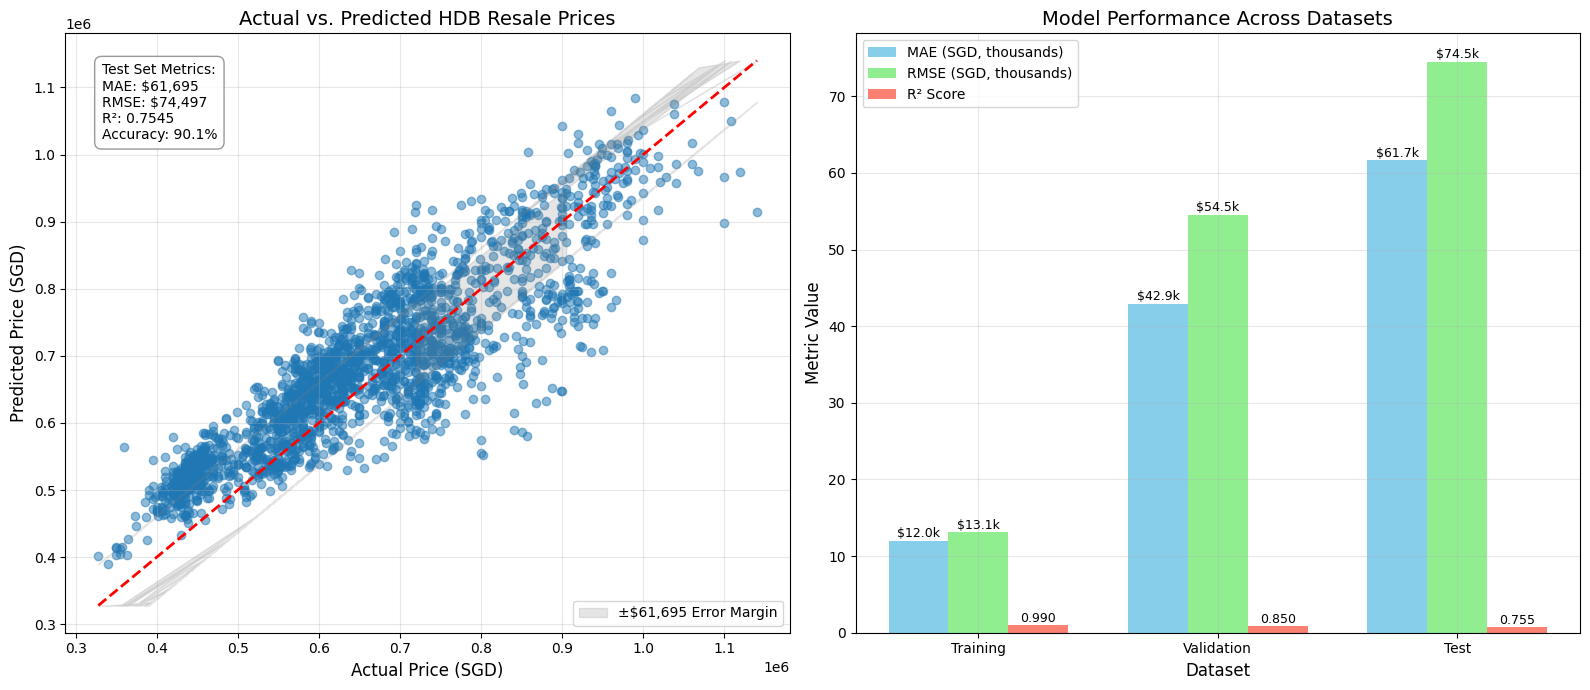


Visualization complete! Results saved to 'svr_model_performance.png'


In [27]:
# Function for model evaluation
def evaluate_model(model, X, y, set_name=""):
    # Make predictions on scaled data
    y_pred = model.predict(X)

    # Calculate metrics on the scaled data
    rmse_scaled = np.sqrt(mean_squared_error(y, y_pred))
    mae_scaled = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"\n{set_name} Set Evaluation:")
    print(f"  RMSE: {rmse_scaled:.4f}")
    print(f"  MAE:  {mae_scaled:.4f}")
    print(f"  R²:   {r2:.4f}")

    return rmse_scaled, mae_scaled, r2, y_pred

# Reverse scaling function
def inverse_transform(y_scaled, mean, std):
    return (y_scaled * std) + mean

# Get original mean and std of resale_price
price_mean = original_numerical_stats["resale_price"]["mean"]
price_std = original_numerical_stats["resale_price"]["std"]

# Evaluate on all sets (for scaled metrics)
train_rmse, train_mae, train_r2, y_train_pred = evaluate_model(model, X_train, y_train, "Training")
val_rmse, val_mae, val_r2, y_val_pred = evaluate_model(model, X_val, y_val, "Validation")
test_rmse, test_mae, test_r2, y_test_pred = evaluate_model(model, X_test, y_test, "Test")

# Convert predictions and actual values back to dollar values
y_train_actual_sgd = inverse_transform(y_train, price_mean, price_std)
y_train_pred_sgd = inverse_transform(y_train_pred, price_mean, price_std)

y_val_actual_sgd = inverse_transform(y_val, price_mean, price_std)
y_val_pred_sgd = inverse_transform(y_val_pred, price_mean, price_std)

y_test_actual_sgd = inverse_transform(y_test, price_mean, price_std)
y_test_pred_sgd = inverse_transform(y_test_pred, price_mean, price_std)

# Compute metrics on dollar values
train_mae_sgd = mean_absolute_error(y_train_actual_sgd, y_train_pred_sgd)
train_rmse_sgd = np.sqrt(mean_squared_error(y_train_actual_sgd, y_train_pred_sgd))

val_mae_sgd = mean_absolute_error(y_val_actual_sgd, y_val_pred_sgd)
val_rmse_sgd = np.sqrt(mean_squared_error(y_val_actual_sgd, y_val_pred_sgd))

test_mae_sgd = mean_absolute_error(y_test_actual_sgd, y_test_pred_sgd)
test_rmse_sgd = np.sqrt(mean_squared_error(y_test_actual_sgd, y_test_pred_sgd))

print("\n===== ACTUAL SINGAPORE DOLLAR METRICS =====")
print(f"Training Set:   RMSE: ${train_rmse_sgd:,.2f}   MAE: ${train_mae_sgd:,.2f}")
print(f"Validation Set: RMSE: ${val_rmse_sgd:,.2f}   MAE: ${val_mae_sgd:,.2f}")
print(f"Test Set:       RMSE: ${test_rmse_sgd:,.2f}   MAE: ${test_mae_sgd:,.2f}")

# Calculate the percentage error relative to average price
print(f"\nAverage HDB Resale Price: ${price_mean:,.2f}")
print(f"Test RMSE as percentage of avg price: {(test_rmse_sgd/price_mean)*100:.2f}%")
print(f"Test MAE as percentage of avg price: {(test_mae_sgd/price_mean)*100:.2f}%")

# Additional useful metrics
mape = np.mean(np.abs((y_test_actual_sgd - y_test_pred_sgd) / y_test_actual_sgd)) * 100

print("\n===== ADDITIONAL METRICS =====")
print(f"MAPE: {mape:.2f}%")
print("* On average, the model's predictions are off by this percentage from the true prices")
print(f"* MAPE under 10% is considered good for real estate price prediction")

print(f"\nR² Score: {test_r2:.4f}")
print("* Measures how much variance in resale prices is explained by the model")
print(f"* {test_r2*100:.2f}% of price variation is captured by the model's features")

# Calculate prediction accuracy as 100% - MAPE
prediction_accuracy = 100 - mape
print(f"\nPrediction Accuracy: {prediction_accuracy:.2f}%")
print("* Represents the percentage of the actual price that the model correctly predicts")

# Add visualization (just 2 key graphs)
plt.figure(figsize=(16, 7))

# Graph 1: Actual vs. Predicted Prices Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_actual_sgd, y_test_pred_sgd, alpha=0.5)
plt.plot([y_test_actual_sgd.min(), y_test_actual_sgd.max()],
         [y_test_actual_sgd.min(), y_test_actual_sgd.max()],
         'r--', linewidth=2)
plt.xlabel('Actual Price (SGD)', fontsize=12)
plt.ylabel('Predicted Price (SGD)', fontsize=12)
plt.title('Actual vs. Predicted HDB Resale Prices', fontsize=14)
plt.grid(True, alpha=0.3)

# Calculate error bounds for visualization
error_margin = test_mae_sgd  # Using MAE as the error margin
upper_bound = [min(price + error_margin, y_test_actual_sgd.max()) for price in y_test_actual_sgd]
lower_bound = [max(price - error_margin, y_test_actual_sgd.min()) for price in y_test_actual_sgd]

# Add error bounds
plt.fill_between(y_test_actual_sgd, lower_bound, upper_bound, color='gray', alpha=0.2,
                label=f'±${error_margin:,.0f} Error Margin')
plt.legend()

# Add text box with metrics
metrics_text = f"Test Set Metrics:\nMAE: ${test_mae_sgd:,.0f}\nRMSE: ${test_rmse_sgd:,.0f}\nR²: {test_r2:.4f}\nAccuracy: {prediction_accuracy:.1f}%"
plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
            va='top', fontsize=10)

# Graph 2: Performance Comparison Across Datasets
plt.subplot(1, 2, 2)

# Calculate metrics for all sets
datasets = ['Training', 'Validation', 'Test']
rmse_values = [train_rmse_sgd/1000, val_rmse_sgd/1000, test_rmse_sgd/1000]  # Convert to thousands
mae_values = [train_mae_sgd/1000, val_mae_sgd/1000, test_mae_sgd/1000]      # Convert to thousands
r2_values = [train_r2, val_r2, test_r2]

# Set up bar positions
x = np.arange(len(datasets))
width = 0.25

# Create grouped bar chart
plt.bar(x - width, mae_values, width, label='MAE (SGD, thousands)', color='skyblue')
plt.bar(x, rmse_values, width, label='RMSE (SGD, thousands)', color='lightgreen')
plt.bar(x + width, r2_values, width, label='R² Score', color='salmon')

plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Model Performance Across Datasets', fontsize=14)
plt.xticks(x, datasets)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(mae_values):
    plt.text(i - width, v + 0.05, f'${v:.1f}k', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.05, f'${v:.1f}k', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(r2_values):
    plt.text(i + width, v + 0.05, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('svr_model_performance.png', dpi=300)
plt.show()

print("\nVisualization complete! Results saved to 'svr_model_performance.png'")